In [1]:
# ! pip install streamlit -q

In [1]:
!pip install pytube

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 5.7 MB/s eta 0:00:00


In [2]:
# changed client from default ANDROID_MUSIC
from pytube.innertube import _default_clients
_default_clients["ANDROID"] = _default_clients["WEB"]


In [3]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import make_grid
import torch
import torch.optim as optim
import itertools
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
import torch
from transformers import DistilBertTokenizer, DistilBertModel, AutoTokenizer

# Load pre-trained DistilBERT model and tokenizer
model_name = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name) # DistilBertTokenizer.from_pretrained(model_name)
model = DistilBertModel.from_pretrained(model_name)

def generate_text_embeddings(texts):
    # Tokenize input texts
    inputs = tokenizer(texts, return_tensors='pt', padding=True, truncation=True)

    # Generate embeddings
    with torch.no_grad():
        outputs = model(**inputs)

    # Get the embeddings from the last hidden layer
    embeddings = outputs.last_hidden_state[:, 0, :] # <---CLS # outputs.last_hidden_state.mean(dim=1)  # You can use other aggregation methods

    return embeddings

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [5]:
import torch
import torch.nn as nn
dropout = 0.1
class ImageProjection(nn.Module):
    def __init__(self, image_embedding_size, shared_embedding_size):
        super(ImageProjection, self).__init__()
        self.image_projection = nn.Linear(image_embedding_size, shared_embedding_size)
        self.gelu = nn.GELU()
        self.fc = nn.Linear(shared_embedding_size, shared_embedding_size)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(shared_embedding_size)

    def forward(self, image_embeddings):
        projected_embeddings = self.image_projection(image_embeddings)

        x = self.gelu(projected_embeddings)
        x = self.fc(x)
        x = self.dropout(x)
        x = x + projected_embeddings
        x = self.layer_norm(x)

        return x # projected_embeddings

class TextProjection(nn.Module):
    def __init__(self, text_embedding_size, shared_embedding_size):
        super(TextProjection, self).__init__()
        self.text_projection = nn.Linear(text_embedding_size, shared_embedding_size)
        self.gelu = nn.GELU()
        self.fc = nn.Linear(shared_embedding_size, shared_embedding_size)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(shared_embedding_size)

    def forward(self, text_embeddings):
        projected_embeddings = self.text_projection(text_embeddings)

        x = self.gelu(projected_embeddings)
        x = self.fc(x)
        x = self.dropout(x)
        x = x + projected_embeddings
        x = self.layer_norm(x)

        return x # projected_embeddings



In [6]:
dropout = 0.1

def cross_entropy(preds, targets, reduction='none'):
    log_softmax = nn.LogSoftmax(dim=-1)
    loss = (-targets * log_softmax(preds)).sum(1)
    if reduction == "none":
        return loss
    elif reduction == "mean":
        return loss.mean()

temperature_value = torch.nn.Parameter(torch.tensor(1.0910))  # Initialize as a learnable parameter

def contrastive_clip_loss_function( text_projection,  image_projection, mode="eval" ):
    logits = (text_projection @ image_projection.T) / temperature_value
    if mode=="train":
        images_similarity = image_projection @ image_projection.T
        texts_similarity = text_projection @ text_projection.T
        targets = F.softmax( (images_similarity + texts_similarity) / 2 * temperature_value, dim=-1 )
        texts_loss = cross_entropy(logits, targets, reduction='none')
        images_loss = cross_entropy(logits.T, targets.T, reduction='none')
        loss =  (images_loss + texts_loss) / 2.0 # shape: (batch_size)
        return loss.mean()
    elif mode=="eval":
        return logits
    else:
        print("Mention mode")
        return None

In [7]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import time
import torch
import torch.nn as nn
import torch.nn.functional as F

In [8]:

shared_embedding_size = 512
learning_rate = 5e-4

image_embedding_size=1024*2
resnet_model = models.resnet50(pretrained=True)
resnet_model = nn.Sequential( *list(resnet_model.children())[:-1] )
resnet_model.to(device)

max_length = 32
text_embedding_size = 768
model_name = 'distilbert-base-uncased'
text_tokenizer = DistilBertTokenizer.from_pretrained(model_name) # .to(device)
text_model = DistilBertModel.from_pretrained(model_name ).to(device)

image_projector = ImageProjection(image_embedding_size, shared_embedding_size).to(device)
text_projector = TextProjection(text_embedding_size, shared_embedding_size).to(device)

params = [{"params":resnet_model.parameters(), "lr":1e-4 }, {"params":text_model.parameters(), "lr":1e-5},
          # {"params":image_projector.parameters(), "lr": }, {"params":text_projector.parameters(), "lr":}
          {"params": itertools.chain( image_projector.parameters(), text_projector.parameters(), [temperature_value] ), "lr":1e-3 , "weight_decay":1e-3 }
         ]
optimizer = optim.AdamW( params,  weight_decay=0. )
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau( optimizer, mode="min", patience=2 , factor=0.8 )


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [9]:
# from google.colab import drive
# drive.mount('/content/drive')


In [11]:
import torch

# Load the saved model checkpoint
checkpoint_path = "/kaggle/input/temp1-432resnetbert/final_odel_from_Scratch_ResNet_DistilBERT.h5"
checkpoint = model = torch.load(checkpoint_path, map_location=torch.device('cpu'))


# Load the state dictionaries into the models and optimizer
resnet_model.load_state_dict(checkpoint['resnet_model_dict'])
text_model.load_state_dict(checkpoint['text_model_dict'])
image_projector.load_state_dict(checkpoint['image_projector_dict'])
text_projector.load_state_dict(checkpoint['text_projector_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
temperature_value_1 = nn.Parameter(torch.tensor(checkpoint['temperature_value']), requires_grad=True)

# Set the models to evaluation mode

image_projector.eval()




ImageProjection(
  (image_projection): Linear(in_features=2048, out_features=512, bias=True)
  (gelu): GELU()
  (fc): Linear(in_features=512, out_features=512, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
)

In [12]:
!pip install datasets

In [13]:
from pytube import YouTube

In [16]:
from datasets import load_dataset

dataset = load_dataset("AlexZigma/msr-vtt")

In [ ]:
dataset['val'][0]

In [17]:
from pytube import YouTube

def download_video(video_url, output_filename):
    try:
        # Choose a video stream with resolution of 360p
        streams = YouTube(url=video_url).streams.filter(adaptive=True, subtype="mp4", resolution="360p", only_video=True)

        # Check if there is a valid stream
        if len(streams) == 0:
            raise Exception("No suitable stream found for this YouTube video!")

        # Download the video
        print("Downloading...")
        streams[0].download(filename=output_filename)
        print("Download completed.")
        return True
    except Exception as e:
        print(f"Error downloading video: {e}")
        return False





In [18]:
import cv2
import os

def extract_frames_with_timestamp(video_file):
    # Open the video file
    cap = cv2.VideoCapture(video_file)

    # Initialize lists to store frame data and timestamps
    frames_list = []
    timestamps_list = []

    # Initialize variables for frame extraction
    fps = cap.get(cv2.CAP_PROP_FPS)
    interval = int(fps)  # Extract one frame per second

    # Initialize frame counter
    frame_count = 0

    # Read frames until the end of the video
    while True:
        # Read a frame from the video
        ret, frame = cap.read()

        # Break the loop if no frame is read
        if not ret:
            break

        # Get the current timestamp (in milliseconds)
        timestamp_ms = cap.get(cv2.CAP_PROP_POS_MSEC)

        # Convert timestamp to seconds
        timestamp_sec = timestamp_ms / 1000.0

        # Check if it's time to extract a frame
        if frame_count % interval == 0:
            # Append frame and timestamp to the lists
            frames_list.append(frame)
            timestamps_list.append(timestamp_sec)

        # Increment frame counter
        frame_count += 1

    # Close the video file
    cap.release()
    print("Frames extracted:", len(frames_list))
    return frames_list, timestamps_list



In [19]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image

class FrameDataset(Dataset):
    def __init__(self, frame_list, image_size=224):
        self.frame_list = frame_list
        self.transform = transforms.Compose([
            transforms.Resize((image_size, image_size)),  # Resize images to a consistent size
            transforms.ToTensor(),  # Convert images to tensors
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize images
        ])

    def __len__(self):
        return len(self.frame_list)

    def __getitem__(self, index):
        frame = self.frame_list[index]

        # Convert NumPy array to PIL Image
        frame_pil = Image.fromarray(frame)

        # Apply transformations
        frame_tensor = self.transform(frame_pil)

        return frame_tensor


In [20]:
resnet_model.eval()
image_projector.eval()
def new_create_image_embeddings(images):
    with torch.no_grad():
        image_embeddings = resnet_model(images)
        image_projection = image_projector(image_embeddings[:,:,0,0])
    return image_projection


def retrieve_frame(frame_dataset, input_query, n ):
    new_image_embeddings_list_train = []

    for index in tqdm(range(len( frame_dataset ))):
        images = frame_dataset[index]
        images = images.to(device)
        image_projection = new_create_image_embeddings(images.unsqueeze(0))
        new_image_embeddings_list_train.append( image_projection[0] )

    with torch.no_grad():
        inputs = tokenizer(input_query, return_tensors='pt', padding="max_length", max_length=max_length, truncation=True)
        inputs = inputs.to(device)
        outputs = text_model(**inputs)
        text_embeddings = outputs.last_hidden_state.mean(dim=1)
        text_projection = text_projector(text_embeddings)

    similarity_scores_list = []
    for index in tqdm(range(len(new_image_embeddings_list_train))):
        score = torch.dot( text_projection[0], new_image_embeddings_list_train[index] )
        similarity_scores_list.append( score.cpu().numpy() )

    max_indexes = np.array(similarity_scores_list).argsort()[-n:][::-1]

    return max_indexes




In [21]:
import matplotlib.pyplot as plt

def display_frames_matching_query(video_url, query):
    # Download the video
    output_filename = "video.mp4"
    if not download_video(video_url, output_filename):
        print("Failed to download video.")
        return

    # Extract frames from the downloaded video
    video_file = "video.mp4"
    frames_list, timestamps_list = extract_frames_with_timestamp(video_file)

    # Retrieve frames matching the query
    frame_dataset = FrameDataset(frames_list)
    indexes = retrieve_frame(frame_dataset, query, n=5)
    selected_frames = [frames_list[i] for i in indexes]
    selected_timestamps = [timestamps_list[i] for i in indexes]

    # Display the frames matching the query and their timestamps
    print(f"Frames matching the query '{query}':")
    for frame, timestamp in zip(selected_frames, selected_timestamps):
        print(f"Timestamp: {timestamp}")
        # Display the frame as an image using matplotlib
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        plt.axis('off')  # Turn off axis
        plt.show()



In [ ]:
dataset['val'][10]

In [ ]:
first_row = dataset['val'][10]
video_url = first_row['url']
start_time = first_row['start time']
end_time = first_row['end time']
query = first_row['caption']
# Call the function
display_frames_matching_query(video_url, query)

Downloading...
Download completed.
Frames extracted: 71


100%|██████████| 71/71 [00:00<00:00, 22642.61it/s]


Frames matching the query 'man holding a gun in his pocket trying to rob a barber shop':
Timestamp: 40.0


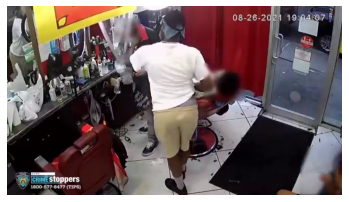

Timestamp: 26.0


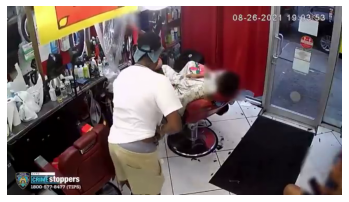

Timestamp: 54.0


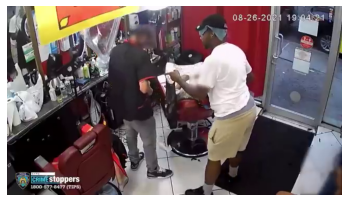

Timestamp: 61.0


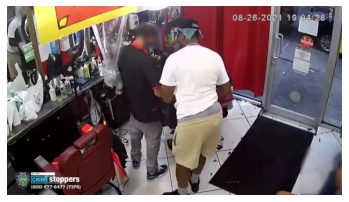

Timestamp: 27.0


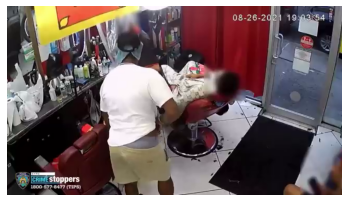

In [25]:
video_url= "https://www.youtube.com/watch?v=1jj3P4bovaY"
query="man holding a gun in his pocket trying to rob a barber shop"
display_frames_matching_query(video_url, query)

Downloading...
Download completed.
Frames extracted: 372


100%|██████████| 372/372 [00:00<00:00, 24202.04it/s]


Frames matching the query 'Riding on decorated elephants are a group of people and a girl in white clothes is dancing ':
Timestamp: 21.0


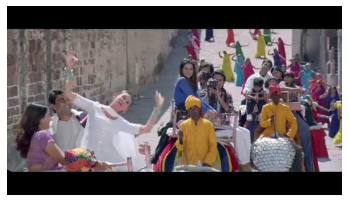

Timestamp: 55.0


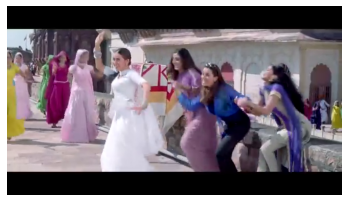

Timestamp: 82.0


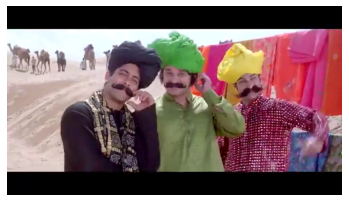

Timestamp: 148.0


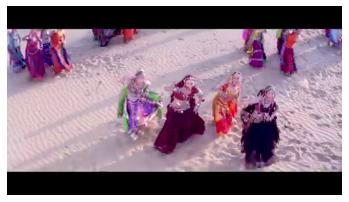

Timestamp: 89.0


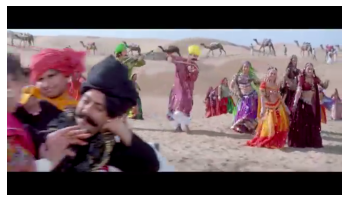

In [28]:
video_url= "https://www.youtube.com/watch?v=3UuSmbx6Xsg"
query="Riding on decorated elephants are a group of people and a girl in white clothes is dancing on elephant"
display_frames_matching_query(video_url, query)

Downloading...
Download completed.
Frames extracted: 11291


100%|██████████| 11291/11291 [00:00<00:00, 25775.52it/s]


Frames matching the query 'a man catching a ball while playing cricket ':
Timestamp: 8141.508374999999


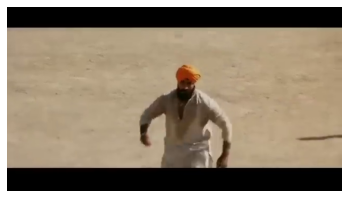

Timestamp: 7696.397041666666


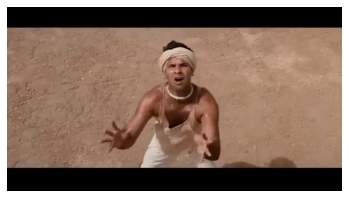

Timestamp: 8048.457083333333


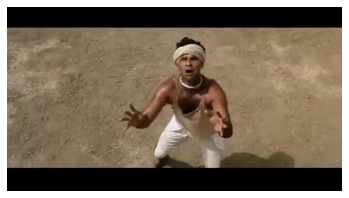

Timestamp: 8142.467666666666


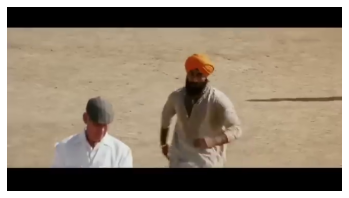

Timestamp: 8965.539916666667


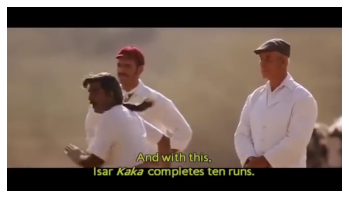

In [33]:
video_url= "https://www.youtube.com/watch?v=vAmsPNCRKro&pp=ygUMbGFnYWFuIG1vdmll"
query="a man catching a ball while playing cricket "
display_frames_matching_query(video_url, query)